## 1.5.2 Class Imbalance Strategy — Data Preparation

In this section, we prepare the processed provider-level dataset for handling
class imbalance. We:

- Load the `provider_features.csv` file generated in Notebook 01.
- Encode the target label (`PotentialFraud`) as 0/1.
- Handle any remaining missing values.
- Split the data into stratified train and test sets, preserving the fraud ratio.

These steps prepare the data so we can correctly apply a class imbalance strategy (SMOTE).


In [6]:
# 1. Load data and basic preprocessing (for class imbalance handling)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# Load provider-level features from Notebook 01
df = pd.read_csv("provider_features.csv")

# Encode target label: No -> 0, Yes -> 1
df["PotentialFraud"] = df["PotentialFraud"].map({"No": 0, "Yes": 1})

# Make sure there are no missing values in the modeling features
df = df.fillna(0)

# Separate features and target
X = df.drop(["Provider", "PotentialFraud"], axis=1)
y = df["PotentialFraud"]

# Stratified train/test split to preserve fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Optional: check class distribution in training set
print("Training class distribution (y_train):")
print(y_train.value_counts(normalize=True))


Training class distribution (y_train):
PotentialFraud
0    0.906581
1    0.093419
Name: proportion, dtype: float64


## 1.5.2 Class Imbalance Strategy — SMOTE Oversampling

The dataset is highly imbalanced (fraudulent providers are a small minority).
To address this, we use **SMOTE (Synthetic Minority Oversampling Technique)** on
the training data only.

This step directly implements the class imbalance strategy required in section 1.5.2.


In [7]:
# 2. Apply SMOTE to balance the training data

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution BEFORE SMOTE:")
print(y_train.value_counts())

print("\nClass distribution AFTER SMOTE:")
print(y_train_res.value_counts())


Class distribution BEFORE SMOTE:
PotentialFraud
0    3678
1     379
Name: count, dtype: int64

Class distribution AFTER SMOTE:
PotentialFraud
0    3678
1    3678
Name: count, dtype: int64


## 1.5.3 Algorithm Selection — Training Selected Models

We now train two different algorithms on the balanced training data:

- **Logistic Regression**: interpretable baseline model.
- **Random Forest**: more powerful tree-based model, robust to mixed features.

This satisfies section 1.5.3 by evaluating relevant algorithms and preparing to
select a primary model.


In [8]:
# 3. Train Logistic Regression and Random Forest on the balanced data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression (interpretable baseline)
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)
log_reg.fit(X_train_res, y_train_res)

# Random Forest (primary model candidate)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train_res, y_train_res)

print("Models trained successfully.")
# Decision Tree (simple baseline)
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
dt.fit(X_train_res, y_train_res)

# Gradient Boosting (strong boosting model)
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb.fit(X_train_res, y_train_res)

print("Decision Tree and Gradient Boosting models trained.")



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Models trained successfully.
Decision Tree and Gradient Boosting models trained.


## 1.5.4 Comparison Models — Evaluation & Metrics

Here we compare Logistic Regression and Random Forest using metrics that are
appropriate for imbalanced classification:

- Precision
- Recall
- F1-score
- ROC-AUC

This fulfills section 1.5.4 by using standardized metrics to compare models.
We will later create curves and deeper error analysis in Notebook 03.


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1226
           1       0.51      0.71      0.60       127

    accuracy                           0.91      1353
   macro avg       0.74      0.82      0.77      1353
weighted avg       0.93      0.91      0.92      1353

ROC-AUC: 0.9204377593094503

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1226
           1       0.40      0.85      0.54       127

    accuracy                           0.86      1353
   macro avg       0.69      0.86      0.73      1353
weighted avg       0.93      0.86      0.88      1353

ROC-AUC: 0.9208295333393276

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1226
           1       0.45      0.61      0.51       127

    accuracy                           0.89      135

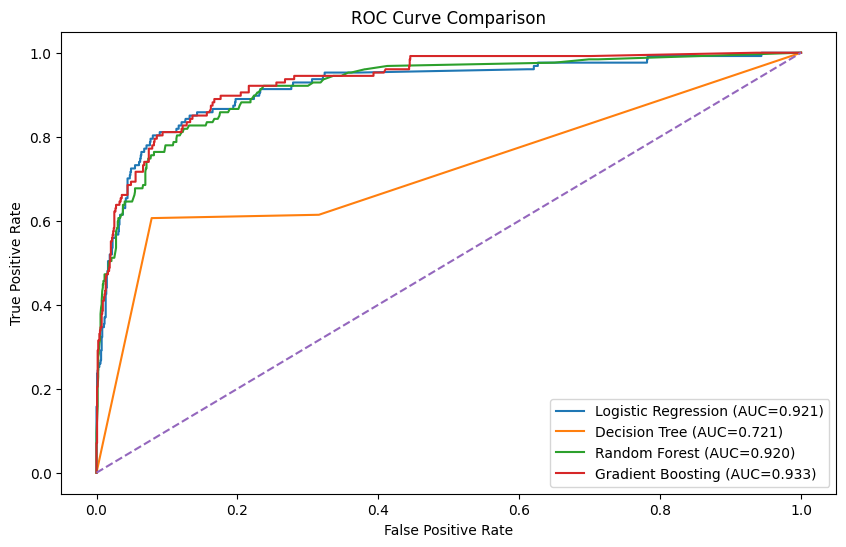

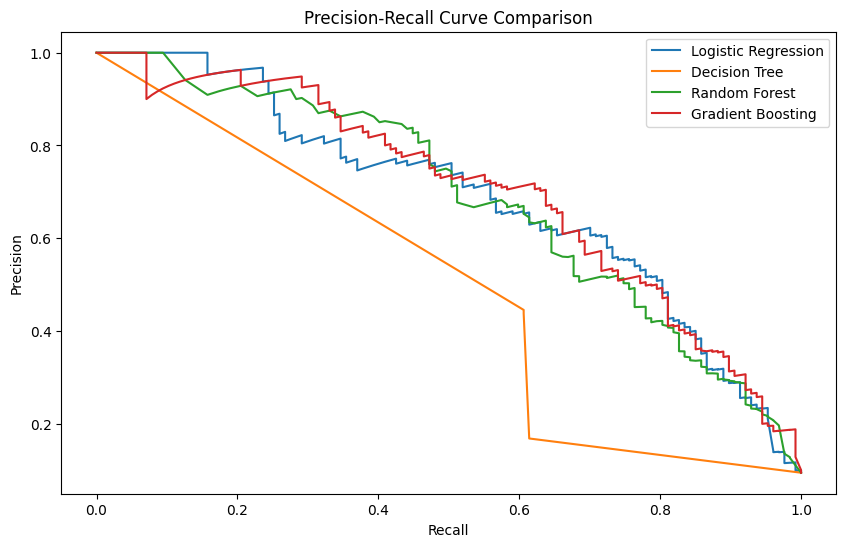


=== Model Comparison Table ===
                 Model   ROC-AUC
0  Logistic Regression  0.920830
1        Decision Tree  0.720893
2        Random Forest  0.920438
3    Gradient Boosting  0.932859


In [9]:
# 4. Evaluate and compare models on the (original) test set

from sklearn.metrics import classification_report, roc_auc_score

# Random Forest predictions
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

# Logistic Regression predictions
log_preds = log_reg.predict(X_test)
log_probs = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_probs))

# --- Decision Tree Evaluation ---
dt_preds = dt.predict(X_test)
dt_probs = dt.predict_proba(X_test)[:,1]

print("\n=== Decision Tree ===")
print(classification_report(y_test, dt_preds))
print("ROC-AUC:", roc_auc_score(y_test, dt_probs))


# --- Gradient Boosting Evaluation ---
gb_preds = gb.predict(X_test)
gb_probs = gb.predict_proba(X_test)[:,1]

print("\n=== Gradient Boosting ===")
print(classification_report(y_test, gb_preds))
print("ROC-AUC:", roc_auc_score(y_test, gb_probs))

# =========================
# ROC & Precision-Recall Curves
# =========================
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

probs_dict = {
    "Logistic Regression": log_probs,
    "Decision Tree": dt_probs,
    "Random Forest": rf_probs,
    "Gradient Boosting": gb_probs,
}

# ROC curves
plt.figure(figsize=(10,6))
for name, probs in probs_dict.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, probs):.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10,6))
for name, probs in probs_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    plt.plot(recall, precision, label=name)
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting"],
    "ROC-AUC": [
        roc_auc_score(y_test, log_probs),
        roc_auc_score(y_test, dt_probs),
        roc_auc_score(y_test, rf_probs),
        roc_auc_score(y_test, gb_probs)
    ]
})

print("\n=== Model Comparison Table ===")
print(comparison)



In [10]:
# 5. Save predictions and probabilities to CSV

# Get the Provider IDs for the test set
providers_test = df.loc[X_test.index, "Provider"]

results = pd.DataFrame({
    "Provider": providers_test,
    "ActualFraud": y_test.values,
    "Pred_RF": rf_preds,
    "Prob_RF": rf_probs,
    "Pred_LR": log_preds,
    "Prob_LR": log_probs,
    "Pred_DT": dt_preds,
    "Prob_DT": dt_probs,
    "Pred_GB": gb_preds,
    "Prob_GB": gb_probs,
})


results.to_csv("model_predictions.csv", index=False)
print("Saved predictions to model_predictions.csv")


Saved predictions to model_predictions.csv
